In [1]:
import torch
import numpy as np
import pandas as pd
import altair as alt
from torch_geometric.nn import Node2Vec
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
import umap
from utils import load_data, get_recipe_string
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import itertools


/home/kurtt/miniforge3/envs/py313/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_normalized, df_bool_collapsed = load_data()

/home/kurtt/cocktail-research/notebooks/utils.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_cols = df.groupby(level=[0, 1], axis=1)
/home/kurtt/cocktail-research/notebooks/utils.py:19: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_cols = df_bool.groupby(level=[0, 1], axis=1)


In [3]:
# Alternative early stopping approaches for your Node2Vec training

# Option 1: Basic early stopping based on loss plateau
def train_with_early_stopping_v1(model, loader, optimizer, device, patience=10, min_delta=1e-4, max_epochs=100):
    """Early stopping based on loss plateau"""
    model.train()
    
    best_loss = float('inf')
    epochs_without_improvement = 0
    loss_history = []
    
    for epoch in range(max_epochs):
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(loader)
        loss_history.append(avg_loss)
        
        print(f'Epoch {epoch:03d}, Loss: {avg_loss:.4f}')
        
        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            epochs_without_improvement = 0
            print(f'    -> New best loss: {best_loss:.4f}')
        else:
            epochs_without_improvement += 1
            print(f'    -> No improvement for {epochs_without_improvement} epochs')
        
        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            print(f'Best loss: {best_loss:.4f}')
            break
    
    return

# Option 2: Early stopping with loss smoothing (rolling average)
def train_with_early_stopping_v2(model, loader, optimizer, device, patience=10, min_delta=1e-4, max_epochs=100, smoothing_window=3):
    """Early stopping with rolling average to reduce noise"""
    model.train()
    
    best_loss = float('inf')
    epochs_without_improvement = 0
    loss_history = []
    
    for epoch in range(max_epochs):
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(loader)
        loss_history.append(avg_loss)
        
        # Use rolling average for smoother early stopping
        if len(loss_history) >= smoothing_window:
            smoothed_loss = np.mean(loss_history[-smoothing_window:])
        else:
            smoothed_loss = avg_loss
        
        print(f'Epoch {epoch:03d}, Loss: {avg_loss:.4f}, Smoothed: {smoothed_loss:.4f}')
        
        if smoothed_loss < best_loss - min_delta:
            best_loss = smoothed_loss
            epochs_without_improvement = 0
            print(f'    -> New best smoothed loss: {best_loss:.4f}')
        else:
            epochs_without_improvement += 1
            print(f'    -> No improvement for {epochs_without_improvement} epochs')
        
        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            print(f'Best smoothed loss: {best_loss:.4f}')
            break
    
    return loss_history

# Option 3: Early stopping with percentage change threshold
def train_with_early_stopping_v3(model, loader, optimizer, device, patience=10, min_percent_change=0.1, max_epochs=100):
    """Early stopping based on percentage change in loss"""
    model.train()
    
    best_loss = float('inf')
    epochs_without_improvement = 0
    loss_history = []
    
    for epoch in range(max_epochs):
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(loader)
        loss_history.append(avg_loss)
        
        print(f'Epoch {epoch:03d}, Loss: {avg_loss:.4f}')
        
        # Check percentage improvement
        if best_loss != float('inf'):
            percent_improvement = ((best_loss - avg_loss) / best_loss) * 100
            if percent_improvement >= min_percent_change:
                best_loss = avg_loss
                epochs_without_improvement = 0
                print(f'    -> {percent_improvement:.2f}% improvement, new best: {best_loss:.4f}')
            else:
                epochs_without_improvement += 1
                print(f'    -> Only {percent_improvement:.2f}% improvement (need {min_percent_change}%), patience: {epochs_without_improvement}')
        else:
            best_loss = avg_loss
            epochs_without_improvement = 0
        
        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            print(f'Best loss: {best_loss:.4f}')
            break
    
    return loss_history


In [4]:
df_normalized, df_bool_collapsed = load_data()

/home/kurtt/cocktail-research/notebooks/utils.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_cols = df.groupby(level=[0, 1], axis=1)
/home/kurtt/cocktail-research/notebooks/utils.py:19: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_cols = df_bool.groupby(level=[0, 1], axis=1)


In [5]:
recipes, ingredients = df_bool_collapsed.shape

# Create edge list for bipartite graph
rows, cols = np.nonzero(df_bool_collapsed)
# Map ingredient indices to start after recipe indices
edge_index = torch.tensor(
    [
        np.concatenate([rows, cols + recipes]),  # source nodes
        np.concatenate([cols + recipes, rows]),  # target nodes (bidirectional)
    ],
    dtype=torch.long,
)

# Create PyTorch Geometric data object
data = Data(edge_index=edge_index, num_nodes=recipes + ingredients)

splitter = RandomLinkSplit(
    num_val=0,          # No validation edges
    num_test=0.1,         # 10 % test edges
    is_undirected=True,   # recipe–ingredient graph is undirected
    neg_sampling_ratio=1, # 1 negative edge per positive
    add_negative_train_samples=False,  # you already do negative sampling in Node2Vec
    split_labels=True,
    key="edge_label",
)
train_data, _, test_data = splitter(data)


/tmp/ipykernel_82624/1246399784.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor(


In [6]:
def edge_operator(u, v):                    # simple Hadamard product
    return u * v


def train_and_evaluate_node2vec(data: Data, embedding_dim=64, p=1.0, q=0.5, walk_length=20, context_size=10, walks_per_node=10) -> float:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Node2Vec(
        train_data.edge_index,
        embedding_dim=embedding_dim,
        walk_length=walk_length,
        context_size=context_size,
        walks_per_node=walks_per_node,
        num_negative_samples=1,
        p=p,  # return parameter
        q=q,  # in-out parameter
        sparse=True,
    ).to(device)

    # Create data loader
    loader = model.loader(batch_size=128, shuffle=True, num_workers=4)

    # Optimizer
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)
    train_with_early_stopping_v1(
        model, loader, optimizer, device, patience=10, min_delta=1e-4, max_epochs=100
    )
    model.eval()
    with torch.no_grad():
        embeddings = model().cpu().numpy()

    # Create features for positive edges (label = 1)
    X_pos = edge_operator(
        embeddings[test_data.pos_edge_label_index[0]],
        embeddings[test_data.pos_edge_label_index[1]],
    )

    # Create features for negative edges (label = 0)
    X_neg = edge_operator(
        embeddings[test_data.neg_edge_label_index[0]],
        embeddings[test_data.neg_edge_label_index[1]],
    )

    # Combine positive and negative features
    X_val = np.vstack([X_pos, X_neg])

    # Create labels: 1 for positive edges, 0 for negative edges
    y_pos = np.ones(X_pos.shape[0])
    y_neg = np.zeros(X_neg.shape[0])
    y_val = np.concatenate([y_pos, y_neg])

    # Train classifier and compute AUC
    clf = LogisticRegression(max_iter=1000).fit(X_val, y_val)
    auc = roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])

    print(f"AUC Score: {auc:.4f}")
    return auc, model



In [9]:
results = []
reps = 3
p_q_range = [0.25, 0.5, 1.0, 2.0, 4.0]
for p, q in itertools.product(p_q_range, p_q_range):
    aucs = []
    for rep in range(reps):
        auc, model = train_and_evaluate_node2vec(data=data, p=p, q=q)
        aucs.append(auc)
    results.append({"p": p, "q": q, "auc_mean": np.mean(aucs), "auc_std": np.std(aucs)})

results_df = pd.DataFrame(results)

Epoch 000, Loss: 6.0822
    -> New best loss: 6.0822
Epoch 001, Loss: 4.8884
    -> New best loss: 4.8884
Epoch 002, Loss: 3.9961
    -> New best loss: 3.9961
Epoch 003, Loss: 3.3269
    -> New best loss: 3.3269
Epoch 004, Loss: 2.8217
    -> New best loss: 2.8217
Epoch 005, Loss: 2.4400
    -> New best loss: 2.4400
Epoch 006, Loss: 2.1466
    -> New best loss: 2.1466
Epoch 007, Loss: 1.9179
    -> New best loss: 1.9179
Epoch 008, Loss: 1.7410
    -> New best loss: 1.7410
Epoch 009, Loss: 1.6046
    -> New best loss: 1.6046
Epoch 010, Loss: 1.4976
    -> New best loss: 1.4976
Epoch 011, Loss: 1.4166
    -> New best loss: 1.4166
Epoch 012, Loss: 1.3538
    -> New best loss: 1.3538
Epoch 013, Loss: 1.3032
    -> New best loss: 1.3032
Epoch 014, Loss: 1.2683
    -> New best loss: 1.2683
Epoch 015, Loss: 1.2346
    -> New best loss: 1.2346
Epoch 016, Loss: 1.2122
    -> New best loss: 1.2122
Epoch 017, Loss: 1.1928
    -> New best loss: 1.1928
Epoch 018, Loss: 1.1768
    -> New best loss: 

In [11]:
results_df.sort_values(by="auc_mean", ascending=False)

,p,q,auc_mean,auc_std
4,0.25,4.00,0.690496,0.005446
17,2.00,1.00,0.670081,0.010110
15,2.00,0.25,0.668917,0.016213
14,1.00,4.00,0.668302,0.007167
11,1.00,0.50,0.665183,0.014400
2,0.25,1.00,0.663267,0.022402
13,1.00,2.00,0.661741,0.013361
23,4.00,2.00,0.660883,0.002564
5,0.50,0.25,0.660658,0.013966
3,0.25,2.00,0.660609,0.009589


In [20]:
p = 1
q = 1
embedding_dims = [32, 64, 128]
for embedding_dim in embedding_dims:
    auc = train_and_evaluate_node2vec(data=data, p=p, q=q, embedding_dim=embedding_dim)
    results.append({"p": p, "q": q, "embedding_dim": embedding_dim, "auc": auc})

results_df = pd.DataFrame(results)

Epoch 000, Loss: 4.2812
    -> New best loss: 4.2812
Epoch 001, Loss: 3.5158
    -> New best loss: 3.5158
Epoch 002, Loss: 2.9252
    -> New best loss: 2.9252
Epoch 003, Loss: 2.4676
    -> New best loss: 2.4676
Epoch 004, Loss: 2.1234
    -> New best loss: 2.1234
Epoch 005, Loss: 1.8582
    -> New best loss: 1.8582
Epoch 006, Loss: 1.6714
    -> New best loss: 1.6714
Epoch 007, Loss: 1.5347
    -> New best loss: 1.5347
Epoch 008, Loss: 1.4377
    -> New best loss: 1.4377
Epoch 009, Loss: 1.3657
    -> New best loss: 1.3657
Epoch 010, Loss: 1.3163
    -> New best loss: 1.3163
Epoch 011, Loss: 1.2749
    -> New best loss: 1.2749
Epoch 012, Loss: 1.2458
    -> New best loss: 1.2458
Epoch 013, Loss: 1.2211
    -> New best loss: 1.2211
Epoch 014, Loss: 1.2013
    -> New best loss: 1.2013
Epoch 015, Loss: 1.1883
    -> New best loss: 1.1883
Epoch 016, Loss: 1.1745
    -> New best loss: 1.1745
Epoch 017, Loss: 1.1658
    -> New best loss: 1.1658
Epoch 018, Loss: 1.1559
    -> New best loss: 

In [21]:
results_df

,p,q,auc,embedding_dim
0,0.2500,0.2500,0.716870,NaN
1,0.5000,0.5000,0.685762,NaN
2,1.0000,1.0000,0.697395,NaN
3,2.0000,2.0000,0.670656,NaN
4,4.0000,4.0000,0.654522,NaN
5,0.0625,0.0625,0.677251,NaN
6,0.1250,0.1250,0.664497,NaN
7,0.2500,0.2500,0.673646,NaN
8,1.0000,1.0000,0.634584,32.0
9,1.0000,1.0000,0.658999,64.0


In [24]:
embeddings.shape

(1816, 64)

In [ ]:
model.eval()
with torch.no_grad():
    embeddings = model().cpu().numpy()

recipe_embeddings = embeddings[:recipes]
ingredient_embeddings = embeddings[recipes:]









In [ ]:
# Create heatmap of ingredient factors
def create_ingredient_heatmap(H: np.ndarray, ingredient_names: list[str], 
                             n_components_show: int = 15, n_top_ingredients: int = 30) -> None:
    """
    Create a heatmap showing the top ingredients for each component.
    
    Args:
        H: Ingredient factors matrix (n_components x n_ingredients)
        ingredient_names: List of ingredient names
        n_components_show: Number of components to show
        n_top_ingredients: Number of top ingredients to include
    """
    # Get top ingredients overall
    ingredient_importance = np.sum(H, axis=0)
    top_ingredient_indices = np.argsort(ingredient_importance)[-n_top_ingredients:][::-1]
    
    # Create subset of H matrix
    H_subset = H[:n_components_show, top_ingredient_indices]
    
    # Clean ingredient names
    clean_ingredient_names = []
    for idx in top_ingredient_indices:
        ing = ingredient_names[idx]
        if isinstance(ing, tuple):
            clean_ingredient_names.append(f"{ing[0]}-{ing[1]}")
        else:
            clean_ingredient_names.append(str(ing))
    
    # Create heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(
        H_subset,
        xticklabels=clean_ingredient_names,
        yticklabels=[f'Component {i+1}' for i in range(n_components_show)],
        cmap='viridis',
        cbar_kws={'label': 'Factor Weight'}
    )
    plt.title(f'NMF Ingredient Factors Heatmap\n(Top {n_top_ingredients} Ingredients, {n_components_show} Components)')
    plt.xlabel('Ingredients')
    plt.ylabel('NMF Components')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Create ingredient heatmap
create_ingredient_heatmap(H, ingredient_names, n_components_show=15, n_top_ingredients=25)


NameError: name 'List' is not defined

In [35]:
reducer = umap.UMAP(
    n_neighbors=5,
    n_components=2,
    metric="cosine",  # Cosine distance works well for factor matrices
    random_state=42,
)
recipe_umap = reducer.fit_transform(recipe_embeddings)

# Create DataFrame
recipe_embedding_df = pd.DataFrame(
    {
        "UMAP1": recipe_umap[:, 0],
        "UMAP2": recipe_umap[:, 1],
        "recipe_name": df_normalized.index,
    }
)
recipe_embedding_df["ingredients"] = recipe_embedding_df["recipe_name"].apply(
    lambda x: get_recipe_string(df_normalized, x)
)

ingredient_umap = reducer.fit_transform(ingredient_embeddings)
ingredient_embedding_df = pd.DataFrame(
    {
        "UMAP1": ingredient_umap[:, 0],
        "UMAP2": ingredient_umap[:, 1],
        "ingredient_name": df_normalized.columns,
    }
)


/home/kurtt/miniforge3/envs/py313/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [36]:

# Create interactive plot with Altair
chart = alt.Chart(recipe_embedding_df).mark_circle().add_params(
    alt.selection_point()
).encode(
    x=alt.X('UMAP1:Q', title='UMAP Dimension 1'),
    y=alt.Y('UMAP2:Q', title='UMAP Dimension 2'),
    tooltip=['recipe_name:N', 'ingredients:N']
).properties(
    width=800,
    height=600,
    title='Recipe Clusters - UMAP Visualization'
).interactive()

# Display the chart
chart.show()


alt.Chart(...)

In [38]:
chart = alt.Chart(ingredient_embedding_df).mark_circle().add_params(
    alt.selection_point()
).encode(
    x=alt.X('UMAP1:Q', title='UMAP Dimension 1'),
    y=alt.Y('UMAP2:Q', title='UMAP Dimension 2'),
    tooltip=['ingredient_name:N']
).properties(
    width=800,
    height=600,
    title='Ingredient Clusters - UMAP Visualization'
).interactive()

# Display the chart
chart.show()


alt.Chart(...)

In [39]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



Embedding Statistics:
Shape: (1514, 64)
Mean magnitude: 1.449
Std magnitude: 0.271

Embedding Space Analysis:
Variance explained by first 10 components: 0.312
Effective dimensionality (90% variance): 49


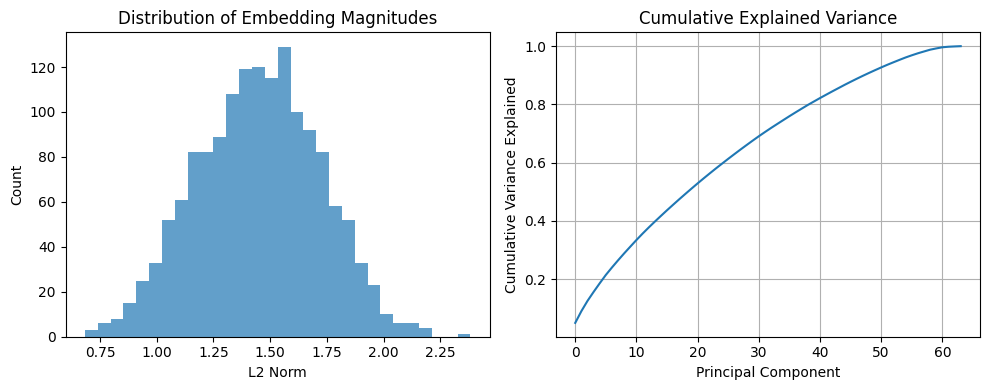

In [19]:
def analyze_embedding_quality(recipe_embeddings):
    """Analyze the quality and characteristics of embeddings"""
    
    # Calculate basic statistics
    print("Embedding Statistics:")
    print(f"Shape: {recipe_embeddings.shape}")
    print(f"Mean magnitude: {np.mean(np.linalg.norm(recipe_embeddings, axis=1)):.3f}")
    print(f"Std magnitude: {np.std(np.linalg.norm(recipe_embeddings, axis=1)):.3f}")
    
    # Check for potential issues
    zero_embeddings = np.sum(np.all(recipe_embeddings == 0, axis=1))
    if zero_embeddings > 0:
        print(f"Warning: {zero_embeddings} recipes have zero embeddings!")
    
    # Analyze embedding space coverage
    pca = PCA()
    pca.fit(recipe_embeddings)
    
    print(f"\nEmbedding Space Analysis:")
    print(f"Variance explained by first 10 components: {np.sum(pca.explained_variance_ratio_[:10]):.3f}")
    print(f"Effective dimensionality (90% variance): {np.sum(np.cumsum(pca.explained_variance_ratio_) < 0.9) + 1}")
    
    # Plot embedding norms
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(np.linalg.norm(recipe_embeddings, axis=1), bins=30, alpha=0.7)
    plt.title('Distribution of Embedding Magnitudes')
    plt.xlabel('L2 Norm')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Variance Explained')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
analyze_embedding_quality(recipe_embeddings)